In [2]:
## LIBRARIES
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split


randomseed = 1234

## DATA LOADING AND PREPROCESSING
# Load the data
gym = pd.read_csv('../../gym_members_exercise_tracking.csv')

# set 'Gender', 'Workout_Type', 'Workout_Frequency (days/week)' and 'Experience_Level' as categorical
for col in ['Gender', 'Workout_Type', 'Workout_Frequency (days/week)', 'Experience_Level']:
    gym[col] = gym[col].astype('category')

# log transform Weight and BMI
gym['Weight (kg)'] = np.log1p(gym['Weight (kg)'])

# transform 'Fat_Percentage'
max_fat = gym['Fat_Percentage'].max()
gym['Fat_Percentage'] = gym['Fat_Percentage'].apply(lambda x: np.sqrt(max_fat+1)-x)

# rename transformed columns
gym.rename(columns={'Weight (kg)': 'LWeight', 'Fat_Percentage': 'SFat_Percentage'}, inplace=True)

gym.drop(columns=['BMI'], inplace=True)

# divide into train and test set
gym_train, gym_test = train_test_split(gym, test_size=0.2, random_state=randomseed)

# Create gym_train_scale, gym_test_scale
gym_train_scale = gym_train.copy()
gym_test_scale = gym_test.copy()

# Scale the data
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
gym_train_scale[['LWeight', 'Height (m)', 'Max_BPM', 'Avg_BPM', 'Resting_BPM', 'Session_Duration (hours)',
                             'Water_Intake (liters)', 'SFat_Percentage', 'Workout_Frequency (days/week)', 'Calories_Burned']] = scaler.fit_transform(gym_train_scale[['LWeight', 'Height (m)', 'Max_BPM', 'Avg_BPM', 'Resting_BPM', 'Session_Duration (hours)',
                             'Water_Intake (liters)', 'SFat_Percentage', 'Workout_Frequency (days/week)', 'Calories_Burned']])

gym_test_scale[['LWeight', 'Height (m)', 'Max_BPM', 'Avg_BPM', 'Resting_BPM', 'Session_Duration (hours)',
                             'Water_Intake (liters)', 'SFat_Percentage', 'Workout_Frequency (days/week)', 'Calories_Burned']] = scaler.transform(gym_test_scale[['LWeight', 'Height (m)', 'Max_BPM', 'Avg_BPM', 'Resting_BPM', 'Session_Duration (hours)',
                             'Water_Intake (liters)', 'SFat_Percentage', 'Workout_Frequency (days/week)', 'Calories_Burned']])


# Create X_train_exp_level, X_test_exp_level, y_train_exp_level, y_test_exp_level
X_train_exp_level = gym_train.drop(columns=['Experience_Level'])
X_train_exp_level_scale = gym_train_scale.drop(columns=['Experience_Level'])
y_train_exp_level = gym_train['Experience_Level']
X_test_exp_level = gym_test.drop(columns=['Experience_Level'])
X_test_exp_level_scale = gym_test_scale.drop(columns=['Experience_Level'])
y_test_exp_level = gym_test['Experience_Level']

# Create X_train_calories, X_test_calories, y_train_calories, y_test_calories
X_train_calories = gym_train.drop(columns=['Calories_Burned'])
X_train_calories_scale = gym_train_scale.drop(columns=['Calories_Burned'])
y_train_calories = gym_train['Calories_Burned']
X_test_calories = gym_test.drop(columns=['Calories_Burned'])
X_test_calories_scale = gym_test_scale.drop(columns=['Calories_Burned'])
y_test_calories = gym_test['Calories_Burned']

print("Data loaded and preprocessed")

Data loaded and preprocessed


In [3]:
display(gym_train.head().style.background_gradient(cmap='YlGnBu', low=0, high=0, axis=0))
# display unique values of categorical columns
display(gym_train.info())
for col in gym_train.select_dtypes(include='category').columns:
    print(col, gym_train[col].unique())

,Age,Gender,LWeight,Height (m),Max_BPM,Avg_BPM,Resting_BPM,Session_Duration (hours),Calories_Burned,Workout_Type,SFat_Percentage,Water_Intake (liters),Workout_Frequency (days/week),Experience_Level
718,51,Male,4.756173,1.670000,189,139,55,1.380000,950.000000,Yoga,-18.400000,2.500000,3,2
811,27,Male,4.503137,1.870000,169,153,62,1.620000,1363.000000,Strength,-6.700000,3.500000,5,3
366,42,Male,4.348987,1.970000,165,157,65,1.140000,886.000000,HIIT,-16.900000,2.600000,3,2
737,34,Male,4.756173,1.810000,181,167,67,1.360000,1249.000000,Yoga,-18.500000,2.200000,2,1
813,34,Female,4.094345,1.620000,178,150,56,1.130000,847.000000,Cardio,-24.900000,2.400000,4,2


<class 'pandas.core.frame.DataFrame'>
Index: 778 entries, 718 to 815
Data columns (total 14 columns):
 #   Column                         Non-Null Count  Dtype   
---  ------                         --------------  -----   
 0   Age                            778 non-null    int64   
 1   Gender                         778 non-null    category
 2   LWeight                        778 non-null    float64 
 3   Height (m)                     778 non-null    float64 
 4   Max_BPM                        778 non-null    int64   
 5   Avg_BPM                        778 non-null    int64   
 6   Resting_BPM                    778 non-null    int64   
 7   Session_Duration (hours)       778 non-null    float64 
 8   Calories_Burned                778 non-null    float64 
 9   Workout_Type                   778 non-null    category
 10  SFat_Percentage                778 non-null    float64 
 11  Water_Intake (liters)          778 non-null    float64 
 12  Workout_Frequency (days/week)  778 non-

None

Gender ['Male', 'Female']
Categories (2, object): ['Female', 'Male']
Workout_Type ['Yoga', 'Strength', 'HIIT', 'Cardio']
Categories (4, object): ['Cardio', 'HIIT', 'Strength', 'Yoga']
Workout_Frequency (days/week) [3, 5, 2, 4]
Categories (4, int64): [2, 3, 4, 5]
Experience_Level [2, 3, 1]
Categories (3, int64): [1, 2, 3]


## Arbres et Forest aléatoires
### Arbre de décision

In [5]:
X_train_calories_dummy = pd.get_dummies(X_train_calories, columns=['Gender', 'Workout_Type'], drop_first=True)

X_test_calories_dummy = pd.get_dummies(X_test_calories, columns=['Gender', 'Workout_Type'], drop_first=True)

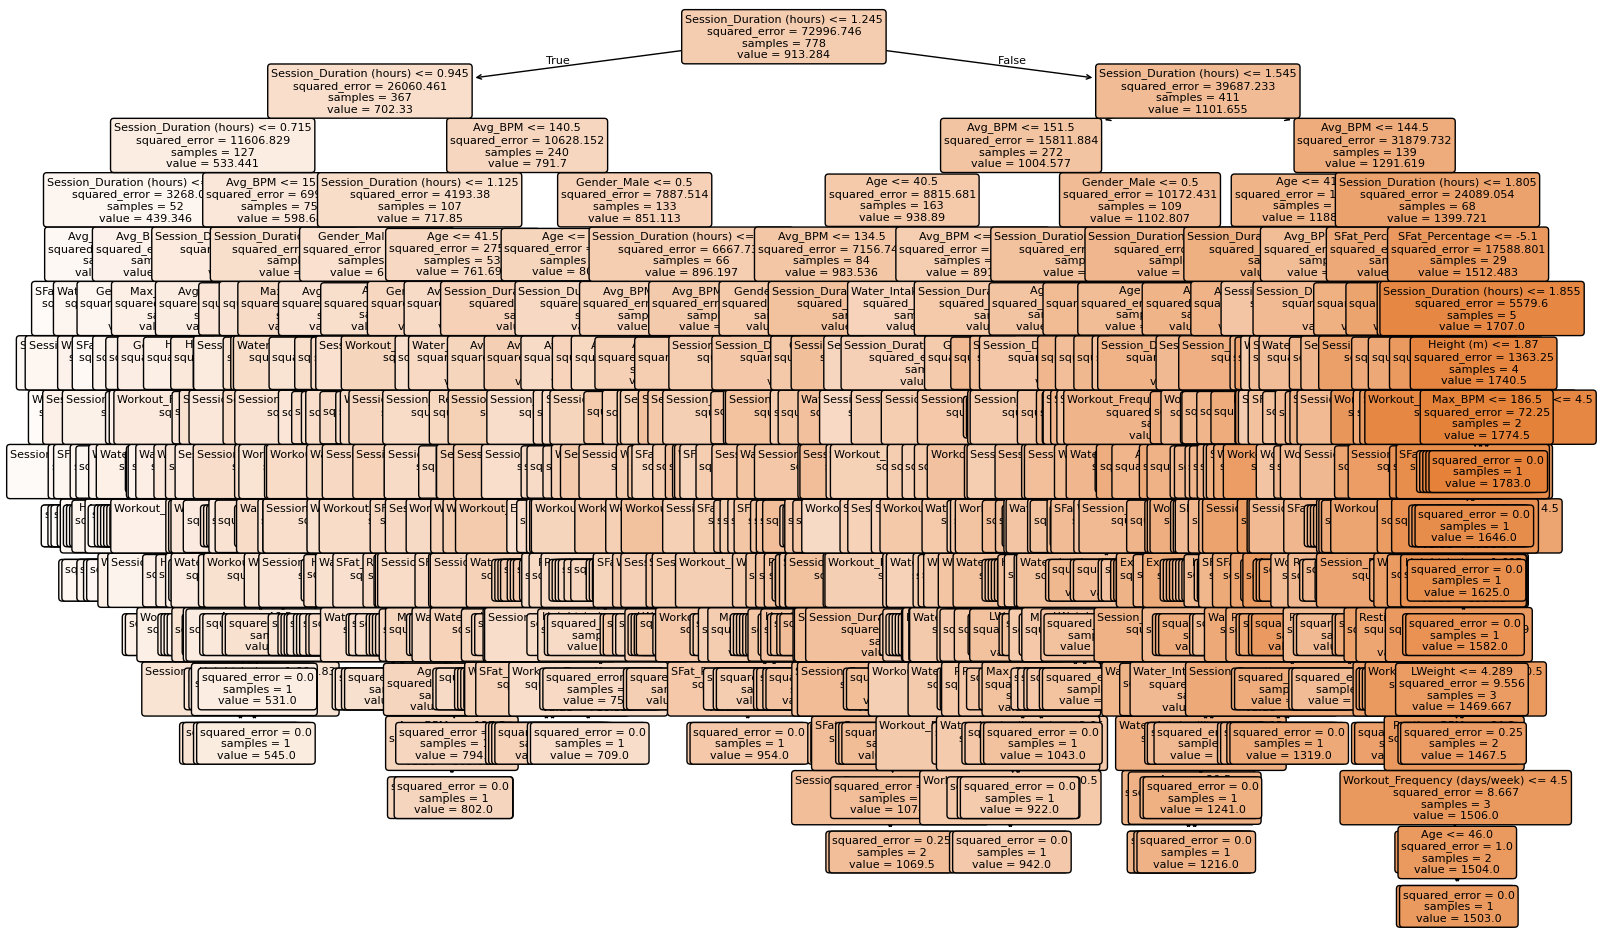

MSE on training set:  0.027849185946872322
MSE on test set:  4484.418091168091
R2 on training set:  0.9999996184872949
R2 on test set:  0.9425477350475702


In [7]:
from sklearn.tree import DecisionTreeRegressor, plot_tree
from sklearn.metrics import mean_squared_error, r2_score

# Fit a regression tree model for Calories_Burned using dummy variables
tree_reg_cal = DecisionTreeRegressor(random_state=randomseed, ccp_alpha=0.001)
tree_reg_cal.fit(X_train_calories_dummy, y_train_calories)

# Plot the tree
plt.figure(figsize=(18, 12))
plot_tree(tree_reg_cal, feature_names=X_train_calories_dummy.columns, filled=True, rounded=True, fontsize=8)
plt.show()

# Compute MSE and R2 on training and test sets
y_train_pred = tree_reg_cal.predict(X_train_calories_dummy)
y_test_pred = tree_reg_cal.predict(X_test_calories_dummy)

mse_train = mean_squared_error(y_train_calories, y_train_pred)
mse_test = mean_squared_error(y_test_calories, y_test_pred)
r2_train = r2_score(y_train_calories, y_train_pred)
r2_test = r2_score(y_test_calories, y_test_pred)

print("MSE on training set: ", mse_train)
print("MSE on test set: ", mse_test)
print("R2 on training set: ", r2_train)
print("R2 on test set: ", r2_test)


**Interprétation** : Nous avons initialement construit un arbre de régression avec un paramètre de complexité extrêmement faible (`cp = 0.01`). Comme attendu, ce modèle présente une structure profondément ramifiée, caractéristique d'un sur-apprentissage. Ce modèle présente queasiment aucun biais sur le jeu d’entraînement (R² = 0.999, MSE = 0.027), mais un écart significatif entre l’erreur d’entraînement et de test (MSE_test = 4484) révèle un sur-apprentissage. Toutefois, le R² sur le test reste élevé (0.934), indiquant que le modèle capture une part substantielle de la variance explicative, malgré sa complexité excessive. Le modèle d'arbre en Python est plus complexe qu'en R alors que nous utilisons un cp plus élevé (`cp=0.01`), tandis que R utilise un `cp=0.001`. 

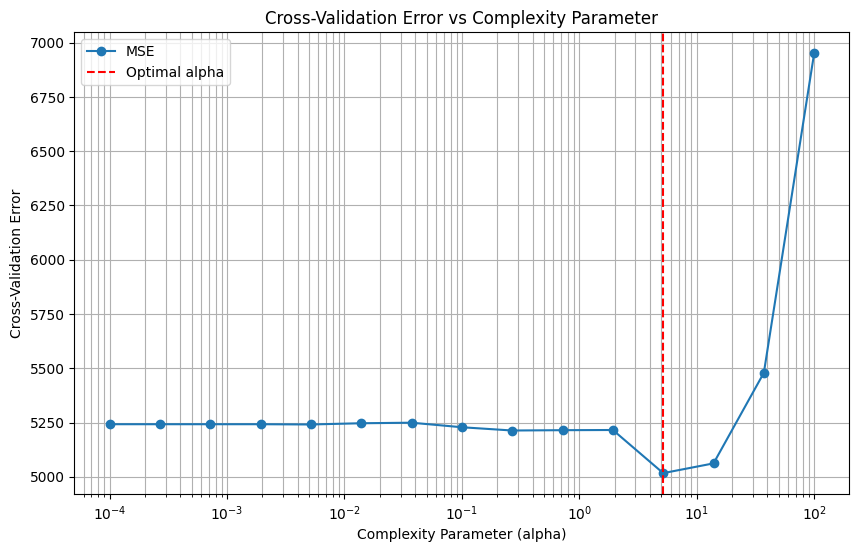

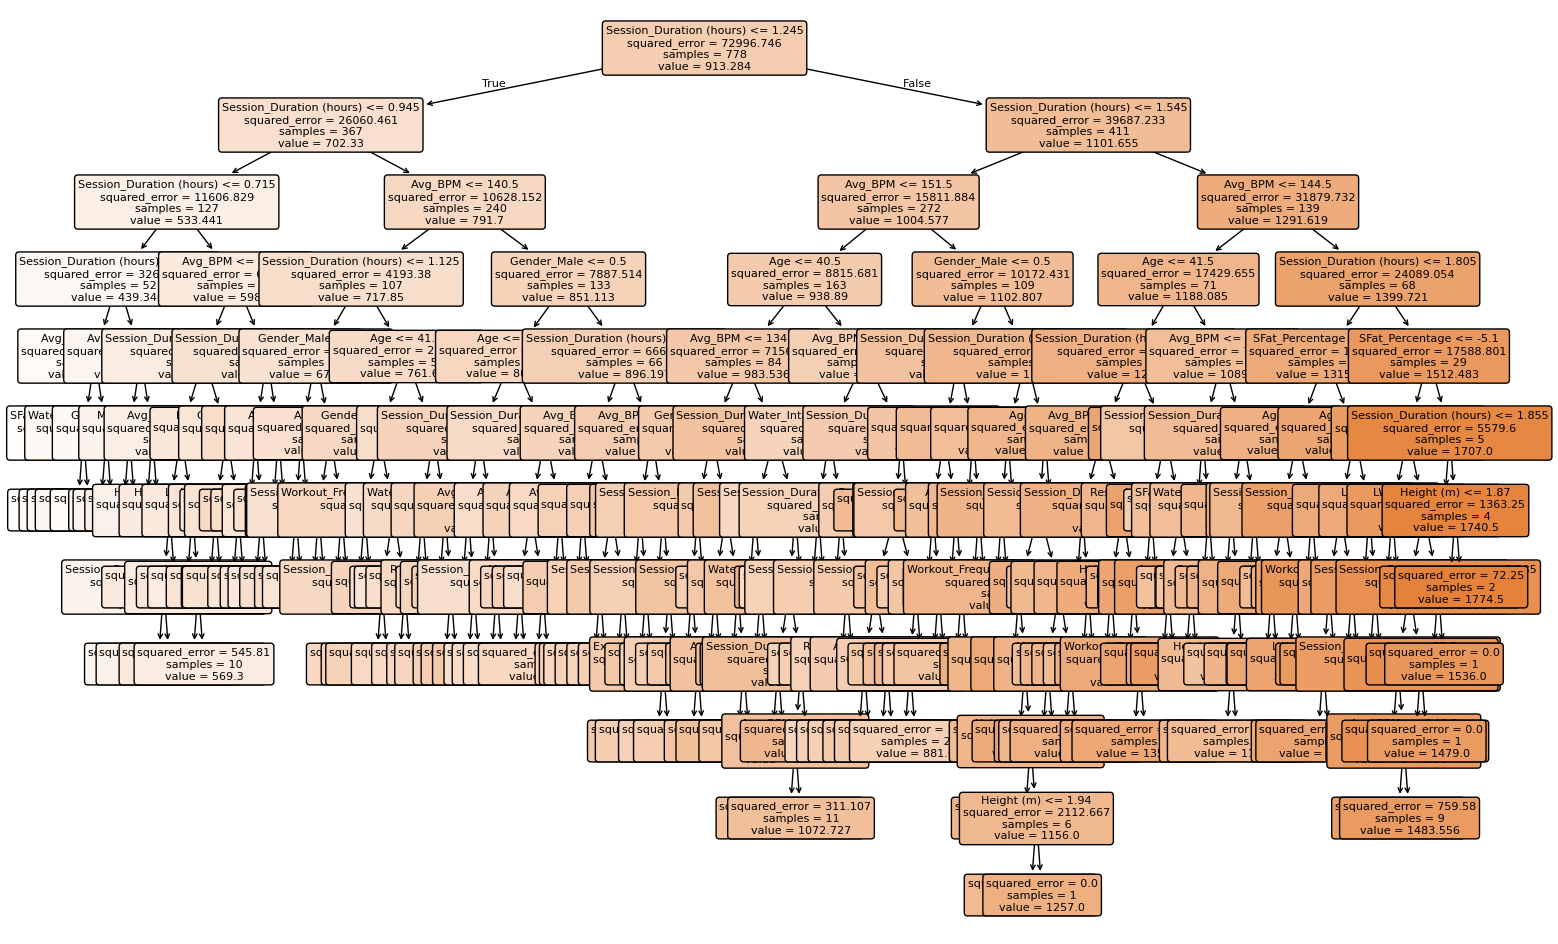

,param_ccp_alpha,mean_test_neg_mse,std_test_neg_mse,rank_test_neg_mse
11,5.179475,-5016.885403,624.392205,1
12,13.894955,-5061.776704,798.273454,2
8,0.268270,-5213.184856,462.166484,3
9,0.719686,-5214.708946,473.413916,4
10,1.930698,-5215.561973,545.768010,5


,param_ccp_alpha,mean_test_r2,std_test_r2,rank_test_r2
11,5.179475,0.930687,0.007080,1
12,13.894955,0.930117,0.009325,2
10,1.930698,0.927972,0.005673,3
9,0.719686,0.927821,0.006530,4
8,0.268270,0.927791,0.006959,5


In [23]:
# grid search for best cp 

scoring = {
    'r2': 'r2',
    'neg_mse': 'neg_mean_squared_error'
}

from sklearn.model_selection import GridSearchCV

params = {
    'ccp_alpha': np.logspace(-4, 2, 15)
}

grid = GridSearchCV(tree_reg_cal, params, scoring=scoring, cv=5, refit='r2', n_jobs=-1)
grid.fit(X_train_calories_dummy, y_train_calories)
grid_results = pd.DataFrame(grid.cv_results_)

# plot the results as a function of ccp_alpha
plt.figure(figsize=(10, 6))
plt.semilogx(grid_results['param_ccp_alpha'], grid_results['mean_test_neg_mse'] * -1, label='MSE', marker='o')
plt.xlabel('Complexity Parameter (alpha)')
plt.ylabel('Cross-Validation Error')
plt.title('Cross-Validation Error vs Complexity Parameter')
plt.grid(True, which="both", ls="-")

optimal_alpha = np.argmin(grid_results['mean_test_neg_mse'] * -1)
plt.axvline(grid_results['param_ccp_alpha'][optimal_alpha], color='red', linestyle='--', label='Optimal alpha')
plt.legend()
plt.show()

# Plot the tree
plt.figure(figsize=(18, 12))
tree_reg_cal_optimal = grid.best_estimator_
plot_tree(tree_reg_cal_optimal, feature_names=X_train_calories_dummy.columns, filled=True, rounded=True, fontsize=8)
plt.show()

# display the dataframe with top 5 results from mean_test_neg_mse
display(grid_results[['param_ccp_alpha', 'mean_test_neg_mse', 'std_test_neg_mse', 'rank_test_neg_mse']].sort_values(by='mean_test_neg_mse', ascending=False).head(5))
# same for r2
display(grid_results[['param_ccp_alpha', 'mean_test_r2', 'std_test_r2', 'rank_test_r2']].sort_values(by='mean_test_r2', ascending=False).head(5))

**Interprétation** : Par validation croisée, nous avons déterminé que le meilleur paramètre de complexité est `cp ≈ 5.18`. L'arbre de regression résultant est moins complexe que le précédent, mais est encore trop ramifié, comme celui de R. Ce modèle est un peu moins performant que celui de R, avec un MSE calculé par cross-validation 5-fold de 5017 ici contre 4521 pour le modèle de R. Le R² est similaire dans les deux langages (~0.93) en revanche. Cela souligne que le modèle de régression est tout de même robuste, malgré la complexité de l'arbre.

Nous allons pouvoir explorer d'autres méthodes d'arbres de décision, comme les forêts aléatoires et le boosting, qui sont souvent plus performantes que les arbres de décision simples. 


### Forêts aléatoires

#### Simple random forest

In [30]:
from sklearn.ensemble import RandomForestRegressor

# Créer et entraîner une forêt aléatoire
rf_reg_cal = RandomForestRegressor(random_state=randomseed, oob_score=True)
rf_reg_cal.fit(X_train_calories_dummy, y_train_calories)

# Prédictions sur les ensembles d'entraînement et de test
y_train_pred_rf = rf_reg_cal.predict(X_train_calories_dummy)
y_test_pred_rf = rf_reg_cal.predict(X_test_calories_dummy)

# Calculer le MSE et le R2
mse_train_rf = mean_squared_error(y_train_calories, y_train_pred_rf)
mse_test_rf = mean_squared_error(y_test_calories, y_test_pred_rf)
r2_train_rf = r2_score(y_train_calories, y_train_pred_rf)
r2_test_rf = r2_score(y_test_calories, y_test_pred_rf)

print("Random Forest - OOB score :", rf_reg_cal.oob_score_)

Random Forest - OOB score : 0.9746206133598264


**Interprétation** : Le modèle de base basique aléatoire de `scikit-learn` est construit avec 100 arbres, avec les paramètres `min_samples_split = 2` (nombre minimum d'élements pour considérer une décision) et `min_samples_leaf = 1` (nombre minimum d'élement dans une feuille). Ces paramètres sont les valeurs par défaut de `scikit-learn`, mais nous allons les optimiser par la suite. 

Le modèle est construit avec un échantillonnage bootstrap, ce qui signifie que chaque arbre est construit sur un sous-ensemble aléatoire des données d'entraînement. Cela nous permet d'extraire l'erreur OOB qui est calculé par défaut avec le score R² dans `scikit-learn`, alors qu'en R, elle est traditionnellement évaluée via la somme des résidus au carré (RSS, Residual Sum of Squares).

Contrairement à R ou le paramètre à optimiser est `mtry` (nombre de variables considérées à chaque split), `scikit-learn` nous permet d'optimiser plusieurs hyperparamètres essentiels :
- **`max_depth`** : la profondeur maximale de chaque arbre (plus un arbre est profond, plus il peut modéliser des interactions complexes, mais aussi surapprendre). 
- **`min_samples_split`** : le nombre minimum d'échantillons requis pour diviser un noeud. Plus il est grand, plus l’arbre est contraint et moins il risque de surapprendre.
- **`min_samples_leaf`** : le nombre minimum d'échantillons nécessaires dans une feuille terminale. Cela permet d’éviter des feuilles trop petites, ce qui améliore la robustesse.
- **`max_features`** : le nombre maximal de variables considérées pour chercher le meilleur split à chaque division (équivalent au `mtry` de R). Peut être fixé à un nombre entier, à une proportion de la taille du sample (`float` entre 0 et 1), ou aux valeurs prédéfinies `'sqrt'` : $\sqrt{n_\text{variables}}$ ou `'log2'` : $\log_2(n_\text{variables})$.
- **`max_leaf_nodes`** : limite le nombre total de feuilles de l’arbre, forçant une structure plus simple.
- **`ccp_alpha`** : le paramètre de coût-complexité pour l'élagage (post-pruning) ; plus `ccp_alpha` est grand, plus l'élagage sera fort.

Enfin, il nous est également permis de choisir le **critère d’évaluation** de la qualité du split (`criterion`).   
Alors qu’en R, la performance est évaluée via le **RSS** (Residual Sum of Squares), l’option la plus proche disponible dans `scikit-learn` est `friedman_mse`, conçue pour optimiser la variance résiduelle de manière similaire au RSS.  
Ici, nous avons l'occasion de comparer l'impact du choix du critère (`friedman_mse` vs `squared_error`) sur la construction des arbres.  

Nous observerons notamment l'effet sur la performance de généralisation (via le score OOB R²) ainsi que sur le temps d'apprentissage et d'élagage.
Le score OOB étant uniquement calculé sur la métrique R² sous `scikit-learn`, le modèle optimal ne sera pas directement comparable aux mesures obtenues en R (RSS).

Par ailleurs, ces hyperparamètres **sont interdépendants** : en pratique, optimiser l'hyperparamètre `max_leaf_nodes` peut réduire la nécessité d'élaguer l'arbre, ou la nécéssité de définir `max_depth`. 

Nous avons décidé de construire un modèle de forêt aléatoire avec les paramètres par défaut et optimiser les hyperparamètres `n_estimators` et `max_features` ainsi que le paramètre `ccp_alpha` pour l'élagage, que nous avons vu en cours, mais que nous avons pas appliqué dans le modèle de R.

#### Random forest avec élagage

Comme les forêts aléatoires sont construits avec un échantillonnage bootstrap, nous pouvons estimer l'**erreur OOB (Out-Of-Bag) pour évaluer la performance du modèle**. Ainsi nous n'avons pas besoin d'utiliser la validation croisée pour évaluer le modèle et déterminer les meilleurs hyperparamètres.

In [ ]:
import itertools
import time
from sklearn.ensemble import RandomForestRegressor
import numpy as np
import pandas as pd
from joblib import Parallel, delayed

# Définir le grille de paramètres
param_grid = {
    'n_estimators': [100, 200, 300, 400, 500],
    'max_features': np.linspace(0.1, 1.0, 10),  # proportion du nombre total de variables
    'ccp_alpha': [0.01, 0.1, 1.0, 5.0, 10.0],
    'criterion': ['friedman_mse', 'squared_error'],  # Comparer plusieurs critères !
    'oob_score': [True],
}

# Générer toutes les combinaisons possibles
keys, values = zip(*param_grid.items())
param_combinations = [dict(zip(keys, v)) for v in itertools.product(*values)]

# Fonction pour entraîner et évaluer
def train_and_evaluate(params):
    model = RandomForestRegressor(random_state=randomseed, **params)
    
    start_time = time.time()
    model.fit(X_train_calories_dummy, y_train_calories)
    elapsed_time = time.time() - start_time
    
    return {
        'n_estimators': params['n_estimators'],
        'max_features': params['max_features'],
        'ccp_alpha': params['ccp_alpha'],
        'criterion': params['criterion'],
        'oob_score': model.oob_score_,
        'training_time_sec': elapsed_time,
    }

# Paralléliser
results = Parallel(n_jobs=-1)(
    delayed(train_and_evaluate)(params) for params in param_combinations
)

# Convertir en DataFrame
results_df = pd.DataFrame(results)

# Trier par oob_score décroissant
results_df = results_df.sort_values(by='oob_score', ascending=False)

# Afficher
display(results_df)


,n_estimators,max_features,ccp_alpha,criterion,oob_score,training_time_sec
481,500,0.9,0.01,squared_error,0.976299,4.553123
480,500,0.9,0.01,friedman_mse,0.976298,4.590707
483,500,0.9,0.10,squared_error,0.976291,4.656172
482,500,0.9,0.10,friedman_mse,0.976290,5.022871
381,400,0.9,0.01,squared_error,0.976226,3.521196
...,...,...,...,...,...,...
306,400,0.1,5.00,friedman_mse,0.792448,1.868355
409,500,0.1,10.00,squared_error,0.792305,2.568135
408,500,0.1,10.00,friedman_mse,0.792208,2.497752
309,400,0.1,10.00,squared_error,0.791624,2.168241


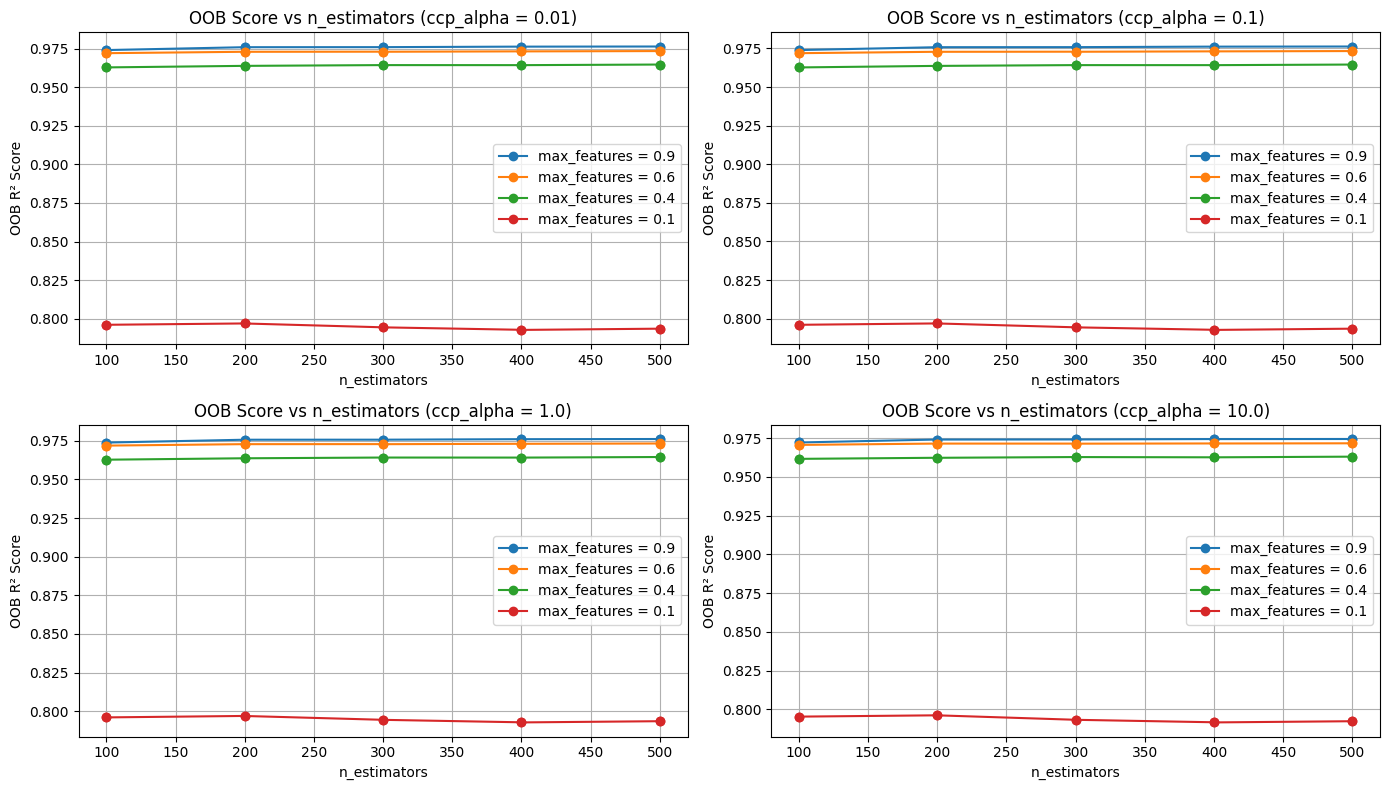

In [ ]:
selected_max_features = [0.9, 0.6, 0.4, 0.1]
selected_ccp_alpha = [0.01, 0.1, 1.0, 10.0]

# Créer 4 sous-graphiques
fig, axes = plt.subplots(2, 2, figsize=(14, 8))  # 2x2 grid
axes = axes.flatten()

for idx, alpha in enumerate(selected_ccp_alpha):
    ax = axes[idx]
    
    # Sous-ensemble des résultats pour ce ccp_alpha
    subset = results_df[results_df['ccp_alpha'] == alpha]
    
    for max_feat in selected_max_features:
        # Prendre uniquement les lignes correspondant à un max_features donné
        curve = subset[np.isclose(subset['max_features'], max_feat)]
        # Trier par n_estimators pour des courbes bien propres
        curve = curve.sort_values('n_estimators')
        
        ax.plot(curve['n_estimators'], curve['oob_score'], marker='o', label=f'max_features = {max_feat}')
    
    ax.set_title(f'OOB Score vs n_estimators (ccp_alpha = {alpha})')
    ax.set_xlabel('n_estimators')
    ax.set_ylabel('OOB R² Score')
    ax.legend()
    ax.grid(True)

plt.tight_layout()
plt.show()

In [47]:
# parmi les 100 meilleures combinaisons, sortir les 10 plus longues à fitter et les 10 plus courtes
best_results_df = results_df[results_df['oob_score'] > 0.974].sort_values(by='training_time_sec', ascending=False).copy()
display(best_results_df.head(10))

display(best_results_df.tail(10))


,n_estimators,max_features,ccp_alpha,criterion,oob_score,training_time_sec
494,500,1.0,1.00,friedman_mse,0.975666,5.211018
495,500,1.0,1.00,squared_error,0.975671,5.196755
486,500,0.9,5.00,friedman_mse,0.975512,5.195596
493,500,1.0,0.10,squared_error,0.975768,5.119858
496,500,1.0,5.00,friedman_mse,0.974810,5.099249
484,500,0.9,1.00,friedman_mse,0.976184,5.034058
479,500,0.8,10.00,squared_error,0.974097,5.032538
482,500,0.9,0.10,friedman_mse,0.976290,5.022871
497,500,1.0,5.00,squared_error,0.974811,4.991758
490,500,1.0,0.01,friedman_mse,0.975774,4.985050


,n_estimators,max_features,ccp_alpha,criterion,oob_score,training_time_sec
71,100,0.8,0.01,squared_error,0.974349,1.103641
81,100,0.9,0.01,squared_error,0.974000,1.102565
95,100,1.0,1.00,squared_error,0.974518,1.042886
94,100,1.0,1.00,friedman_mse,0.974518,1.040030
93,100,1.0,0.10,squared_error,0.974603,1.039476
92,100,1.0,0.10,friedman_mse,0.974603,1.011103
90,100,1.0,0.01,friedman_mse,0.974623,0.981431
72,100,0.8,0.10,friedman_mse,0.974323,0.900841
73,100,0.8,0.10,squared_error,0.974329,0.898502
70,100,0.8,0.01,friedman_mse,0.974343,0.896657


##### **Interprétation des résulats de la forêt aléatoire** :

Nous avons réalisé une analyse fine de la performance de la forêt aléatoire en fonction de plusieurs hyperparamètres (`n_estimators`, `max_features`, `ccp_alpha`), en nous concentrant sur l'estimation de l'erreur de généralisation via l'**OOB score**.

$\rightarrow$ **Influence du critère de split (`criterion`)**

En observant le tableau des résultats, nous constatons que **le choix du critère `friedman_mse` ou `squared_error` n’impacte pratiquement pas la performance du modèle**.  
Que ce soit en termes de **score OOB** ou de **temps d'entraînement**, les deux critères mènent aux **mêmes choix optimaux d'hyperparamètres**, avec des performances quasi-identiques.  
Cela montre que, dans le cas de la forêt aléatoire, **le critère de construction locale des arbres influence peu la qualité globale du modèle**.


$\rightarrow$ **Influence de `max_features`**

Comme nous l'avions observé lors de la modélisation sous R, **plus la proportion de variables sélectionnées à chaque split est élevée, meilleure est la performance de la forêt**.  
Ici, c'est avec `max_features = 0.9` que nous obtenons les meilleurs scores OOB.

En proposant davantage de variables au moment de créer les divisions, chaque arbre a accès à plus d'information pour produire des splits efficaces, ce qui améliore la qualité globale de la forêt.



$\rightarrow$ **Influence de `ccp_alpha` (élagage)**

L'élagage, contrôlé via le paramètre `ccp_alpha`, **semble avoir un effet négligeable sur la performance OOB**.

Quelle que soit la valeur choisie (0.01, 0.1, 1.0, 10.0), l'OOB score reste quasiment stable.  
Cela indique que **le modèle est naturellement robuste** et peu sensible au surapprentissage, même sans élagage agressif.

Cela confirme l'intuition classique en forêt aléatoire : **l'overfitting n'est pas un problème majeur** grâce à l'agrégation de nombreux arbres faibles.


$\rightarrow$ **Performances extrêmes (meilleur modèle)**

- Le **meilleur modèle** atteint un **OOB score** de **0.975666** et a nécessité **5.211 secondes** pour être entraîné.
- Ce modèle utilise :
  - `n_estimators = 500`
  - `max_features = 1.0`
  - `ccp_alpha = 1.0`
  - `criterion = friedman_mse`


$\rightarrow$ **Trade-off performance/temps**

Parmi les modèles ayant un OOB score > 0.974, **le plus rapide** a pris seulement **0.897 secondes** pour un OOB score de **0.974343** (`n_estimators=100`, `max_features=0.8`, `ccp_alpha=0.10`).

Cela montre que **des modèles plus légers peuvent offrir des performances presque équivalentes** tout en étant **beaucoup plus rapides** à entraîner.


$\rightarrow$ **Détail des modèles extrêmes**

- **Top 10 modèles les plus longs à entraîner** (extraits du tableau) : majoritairement avec `n_estimators = 500`.
- **Top 10 modèles les plus rapides** : configurations avec `n_estimators = 100` et `max_features` entre 0.8 et 1.0.

Cela est cohérent avec l'idée que **plus le nombre d'arbres est élevé, plus le temps d'entraînement augmente**.

--- 

**Conclusion** :

Dans l'ensemble, nous constatons que :
- **Un `max_features` élevé** permet d'améliorer significativement la performance du modèle.
- **Le paramètre `ccp_alpha` (élagage) impacte très peu la qualité de la forêt**.
- **Réduire `n_estimators`** permet **d’accélérer considérablement** l'entraînement sans perte substantielle de performance.
- **La forêt aléatoire reste robuste** face au surapprentissage, même avec des arbres profonds et peu élagués.

  
Après avoir validé ces résultats, nous allons désormais nous intéresser à **l’importance des variables**, afin d’identifier les facteurs les plus influents dans la prédiction des calories, comme nous l'avions fait sous R.


##### **Importance des variables**

In [55]:
# fit the best random forest model 

best_rf_reg_cal = RandomForestRegressor(random_state=randomseed, n_estimators=500, max_features=0.9, ccp_alpha=0.01, criterion='friedman_mse', oob_score=True)
best_rf_reg_cal.fit(X_train_calories_dummy, y_train_calories)

# extract variable importance
importances = best_rf_reg_cal.feature_importances_
indices = np.argsort(importances)[::-1]
features = X_train_calories_dummy.columns[indices]
importances = importances[indices]
importances_df = pd.DataFrame({'Feature': features, 'Importance': importances})
importances_df['Cumulative Importance'] = importances_df['Importance'].cumsum()

In [64]:
display(importances_df.head(5))

,Feature,Importance,Cumulative Importance
0,Session_Duration (hours),0.736701,0.736701
1,Avg_BPM,0.105573,0.842274
2,SFat_Percentage,0.052327,0.894601
3,Experience_Level,0.052096,0.946697
4,Age,0.023646,0.970343


C:\Users\doria\AppData\Local\Temp\ipykernel_10488\2443947037.py:2: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(


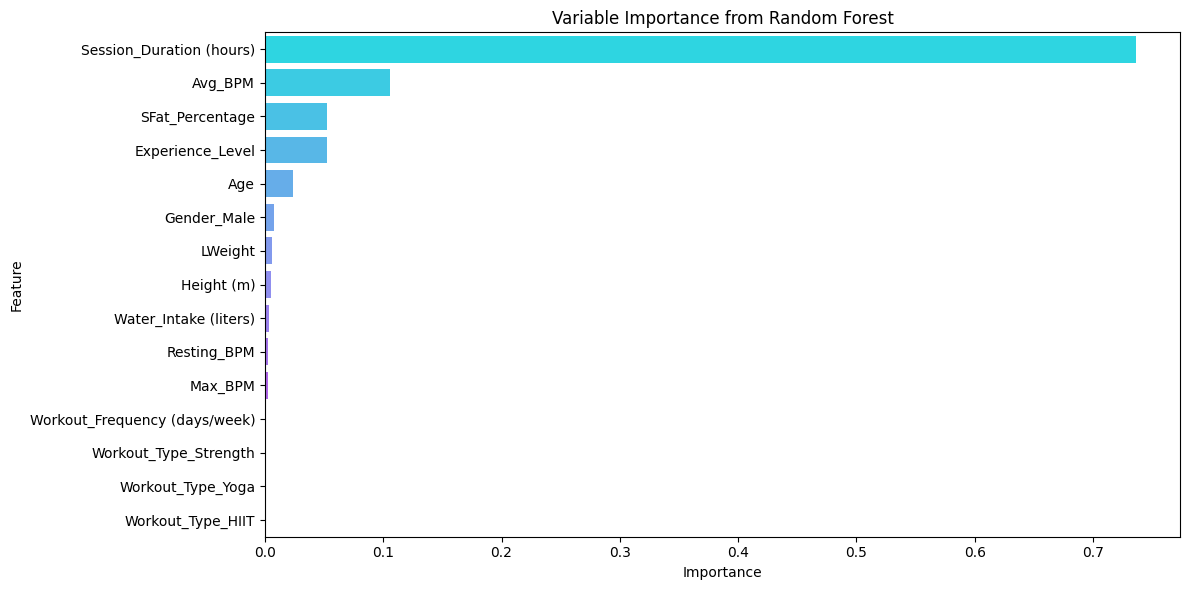

In [62]:
plt.figure(figsize=(12, 6))
sns.barplot(
    x='Importance',
    y='Feature',
    data=importances_df,
    palette='cool',
)
plt.title("Variable Importance from Random Forest")
plt.xlabel("Importance")
plt.ylabel("Feature")
plt.tight_layout()
plt.show()

**Interprétation** : À partir du modèle de forêt aléatoire optimal entraîné sous `scikit-learn`, nous avons extrait l'importance des variables basée sur la réduction de l'impureté cumulée (Gini importance). 

- Le prédicateur `Session_Duration (hours)` domine, expliquant 73.67% de la variance, ce qui est intuitif puisqu'une **session plus longue** implique mécaniquement **une dépense énergétique plus élevée**.
- Il est suivi par `Avg_BPM`, qui contribue à 10.56% de la variance, ce qui est également logique car un rythme cardiaque lors d'une séane de sport plus élevé est souvent associé à une **dépense calorique accrue**.
- Enfin, `SFat_Percentage`, `Experience_Level` et `Age` ont des contributions faibles, mais permettent de capter des interactions intéressantes et améliorent la performance globale du modèle.

On observe ainsi que 5 variables expliquent à elles seules plus de **97 % de l'importance totale du modèle**.

En revanche, sous R, les variables `Session_Duration (hours)` et `Avg_BPM` étaient les seules à ressortir comme les plus importantes, tandis que toutes les autres variables avaient une importance très faible. Ainsi, on peut déduire que `scikit-learn` ne construit pas les forêts aléatoires de la même manière que `caret` sous R.

Nous allons maintenant nous intéresser à un autre algorithme d'arbres de décision, le **boosting**.

### Boosting

Gradient Boosting & XGBoost

In [97]:
from sklearn.model_selection import KFold
from sklearn.ensemble import GradientBoostingRegressor
from xgboost import XGBRegressor
from sklearn.metrics import r2_score, mean_squared_error
import time
import numpy as np
import pandas as pd

# Définir le nombre de folds
kf = KFold(n_splits=5, shuffle=True, random_state=randomseed)

# Stocker les scores et temps
r2_scores_gb = []
mse_scores_gb = []
times_gb = []

r2_scores_xgb = []
mse_scores_xgb = []
times_xgb = []

# Boucle sur les folds
for train_index, val_index in kf.split(X_train_calories):
    X_train_fold, X_val_fold = X_train_calories.iloc[train_index], X_train_calories.iloc[val_index]
    y_train_fold, y_val_fold = y_train_calories.iloc[train_index], y_train_calories.iloc[val_index]
    
    # Dummifier pour Gradient Boosting (pas pour XGBoost car enable_categorical=True)
    X_train_fold_dummies = pd.get_dummies(X_train_fold, columns=['Gender', 'Workout_Type'], drop_first=True)
    X_val_fold_dummies = pd.get_dummies(X_val_fold, columns=['Gender', 'Workout_Type'], drop_first=True)
    
    ## 1. Gradient Boosting
    start_time = time.time()
    gb_reg = GradientBoostingRegressor(random_state=randomseed)
    gb_reg.fit(X_train_fold_dummies, y_train_fold)
    elapsed_time = time.time() - start_time
    y_pred_gb = gb_reg.predict(X_val_fold_dummies)
    
    r2_scores_gb.append(r2_score(y_val_fold, y_pred_gb))
    mse_scores_gb.append(mean_squared_error(y_val_fold, y_pred_gb))
    times_gb.append(elapsed_time)
    
    ## 2. XGBoost
    start_time = time.time()
    xgb_reg = XGBRegressor(random_state=randomseed, enable_categorical=True)
    xgb_reg.fit(X_train_fold, y_train_fold)
    elapsed_time = time.time() - start_time
    y_pred_xgb = xgb_reg.predict(X_val_fold)
    
    r2_scores_xgb.append(r2_score(y_val_fold, y_pred_xgb))
    mse_scores_xgb.append(mean_squared_error(y_val_fold, y_pred_xgb))
    times_xgb.append(elapsed_time)

# Résultats finaux
print(f"Gradient Boosting R² moyen (CV) : {np.mean(r2_scores_gb):.4f} ± {np.std(r2_scores_gb):.4f}")
print(f"Gradient Boosting MSE moyen (CV) : {np.mean(mse_scores_gb):.2f} ± {np.std(mse_scores_gb):.2f}")
print(f"Gradient Boosting Temps moyen d'entraînement (par fold) : {np.mean(times_gb):.2f} sec")

print(f"\nXGBoost R² moyen (CV) : {np.mean(r2_scores_xgb):.4f} ± {np.std(r2_scores_xgb):.4f}")
print(f"XGBoost MSE moyen (CV) : {np.mean(mse_scores_xgb):.2f} ± {np.std(mse_scores_xgb):.2f}")
print(f"XGBoost Temps moyen d'entraînement (par fold) : {np.mean(times_xgb):.2f} sec")

# Performance sur le test final
print(f"\nGradient Boosting R² sur l'ensemble de test : {r2_score(y_test_calories, gb_reg.predict(X_test_calories_dummy)):.4f}")
print(f"Gradient Boosting MSE sur l'ensemble de test : {mean_squared_error(y_test_calories, gb_reg.predict(X_test_calories_dummy)):.2f}")

print(f"XGBoost R² sur l'ensemble de test : {r2_score(y_test_calories, xgb_reg.predict(X_test_calories)):.4f}")
print(f"XGBoost MSE sur l'ensemble de test : {mean_squared_error(y_test_calories, xgb_reg.predict(X_test_calories)):.2f}")

# Comparaison avec Random Forest

print(f"\nRandom Forest R² sur l'ensemble de test : {r2_score(y_test_calories, best_rf_reg_cal.predict(X_test_calories_dummy)):.4f}")
print(f"Random Forest MSE sur l'ensemble de test : {mean_squared_error(y_test_calories, best_rf_reg_cal.predict(X_test_calories_dummy)):.2f}")

Gradient Boosting R² moyen (CV) : 0.9937 ± 0.0014
Gradient Boosting MSE moyen (CV) : 451.17 ± 69.83
Gradient Boosting Temps moyen d'entraînement (par fold) : 0.21 sec

XGBoost R² moyen (CV) : 0.9822 ± 0.0047
XGBoost MSE moyen (CV) : 1269.52 ± 255.84
XGBoost Temps moyen d'entraînement (par fold) : 0.14 sec

Gradient Boosting R² sur l'ensemble de test : 0.9903
Gradient Boosting MSE sur l'ensemble de test : 755.82
XGBoost R² sur l'ensemble de test : 0.9824
XGBoost MSE sur l'ensemble de test : 1377.15

Random Forest R² sur l'ensemble de test : 0.9768
Random Forest MSE sur l'ensemble de test : 1812.48


**Interprétation** 

Les modèles de Gradient Boosting et de XGBoost présentent **d'excellentes performances** sans ajustement particulier des hyperparamètres.  

À l'issue de la validation croisée 5-folds :
- Le Gradient Boosting standard atteint un **R² moyen de 0.9937 ± 0.0014** et un **MSE moyen de 451.17 ± 69.83**,
- Le modèle XGBoost atteint un **R² moyen de 0.9822 ± 0.0047** et un **MSE moyen de 1269.52 ± 255.84**.

Les performances sur l'ensemble de test confirment cette excellente capacité de généralisation :
- Le Gradient Boosting obtient un **R² de 0.9903** et un **MSE de 755.82**,
- Le XGBoost obtient un **R² de 0.9824** et un **MSE de 1377.15**.

On constate ainsi que **les deux modèles généralisent très bien**, sans réel phénomène de surapprentissage.

En termes de coût computationnel, **les deux algorithmes sont très rapides à entraîner**, avec des temps moyens d'entraînement par fold d'environ **0.20 seconde pour Gradient Boosting** et **0.12 seconde pour XGBoost**.

Comparativement, le modèle Random Forest, précédemment optimisé, obtient un **R² de 0.9768** et un **MSE de 1812.48**, tout en nécessitant un **temps d'entraînement beaucoup plus important** (~5.2 secondes).

Comparativement, le modèle Random Forest, précédemment optimisé, obtient un **R² de 0.9768** et un **MSE de 1812.48**, tout en nécessitant un **temps d'entraînement beaucoup plus important** (~5.2 secondes).

Ces résultats confirment que **les méthodes de boosting surpassent les forêts aléatoires** à la fois en termes de performance prédictive et d'efficacité computationnelle.

Compte tenu de **ces résultats très satisfaisants**, notamment pour le Gradient Boosting, nous limiterons notre analyse aux modèles actuels sans procéder à une optimisation poussée de XGBoost.
Toutefois, dans une démarche d'optimisation avancée, une recherche d'hyperparamètres sur XGBoost pourrait encore permettre d'améliorer ses performances.

Dans ce contexte, nous allons désormais nous concentrer sur **l'interprétation de l'importance des variables**.

#### **Importance des variables**

C:\Users\doria\AppData\Local\Temp\ipykernel_10488\2901452903.py:12: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(
C:\Users\doria\AppData\Local\Temp\ipykernel_10488\2901452903.py:24: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(


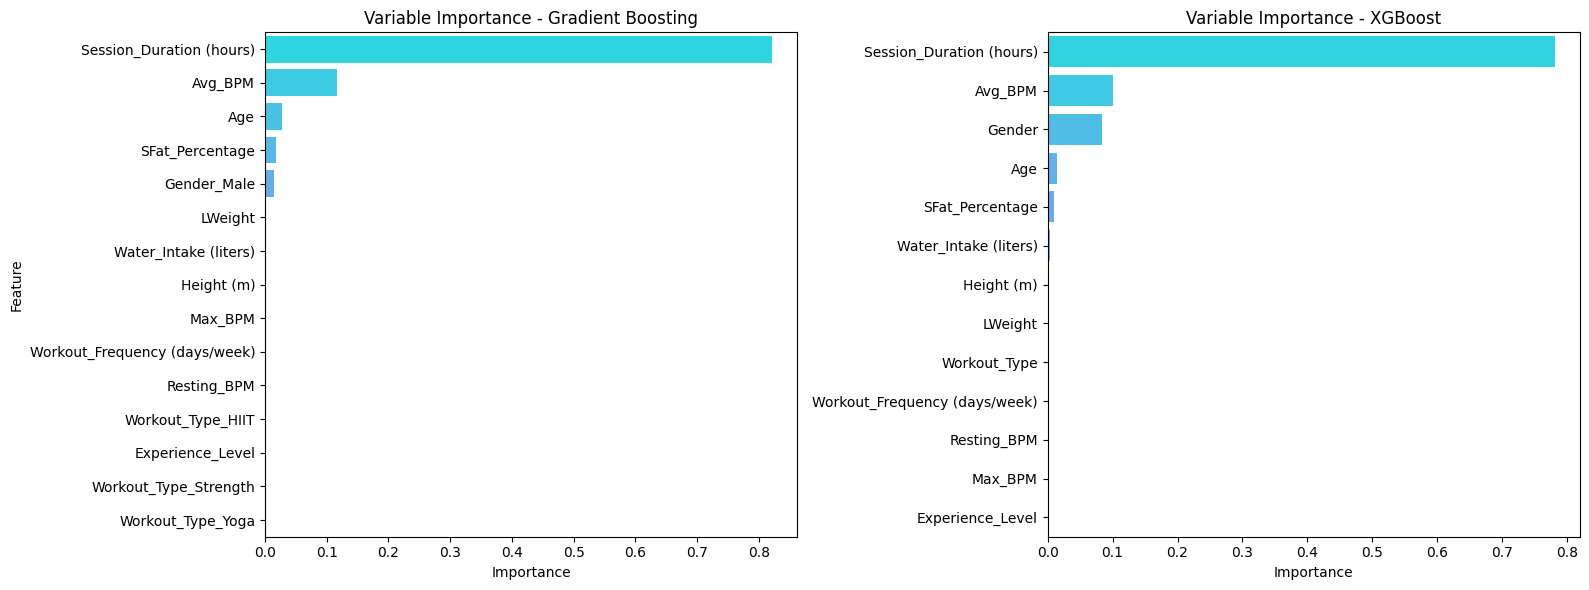

In [93]:
importances_gb_df = pd.DataFrame({'Feature': X_train_calories_dummy.columns, 'Importance': gb_reg.feature_importances_})
importances_xgb_df = pd.DataFrame({'Feature': X_train_calories.columns, 'Importance': xgb_reg.feature_importances_})

# Trier pour plus de lisibilité
importances_gb_df = importances_gb_df.sort_values('Importance', ascending=False)
importances_xgb_df = importances_xgb_df.sort_values('Importance', ascending=False)

# Tracer
fig, axes = plt.subplots(1, 2, figsize=(16, 6))

# Plot pour Gradient Boosting
sns.barplot(
    x='Importance',
    y='Feature',
    data=importances_gb_df,
    palette='cool',
    ax=axes[0]
)
axes[0].set_title("Variable Importance - Gradient Boosting")
axes[0].set_xlabel("Importance")
axes[0].set_ylabel("Feature")

# Plot pour XGBoost
sns.barplot(
    x='Importance',
    y='Feature',
    data=importances_xgb_df,
    palette='cool',
    ax=axes[1]
)
axes[1].set_title("Variable Importance - XGBoost")
axes[1].set_xlabel("Importance")
axes[1].set_ylabel("")  # Pas besoin de répéter "Feature" à droite

plt.tight_layout()
plt.show()


Bien que Gradient Boosting et XGBoost obtiennent des performances très proches en termes de R², une analyse de l'importance des variables révèle des différences notables dans les contributions fines.

Dans les deux modèles, `Session_Duration (hours)` et `Avg_BPM` dominent largement la prédiction, ce qui est cohérent avec les résultats précédents observés sous forêts aléatoires et en R.

Toutefois, lorsque l'on s'intéresse aux variables secondaires, **les importances relatives divergent** :
- Gradient Boosting répartit l'importance restante entre les variables `Age`, `SFat_Percentage` et `Gender_Male` alors que `Experience_Level` est inexistant dans le modèle.
- XGBoost attribue une importance non négligeable directement à `Gender` en le mettant au même niveau que `Avg_BPM`, tandis que `Age` et `SFat_Percentage` restent marginaux.

Ces différences s'expliquent par :
- **La nature des modèles** : XGBoost, utilisant du boosting plus régularisé, capte parfois des combinaisons d'interactions que Gradient Boosting classique ne priorise pas aussi fortement.
- **La manière de calculer l’importance** : Gradient Boosting utilise la réduction moyenne d'impureté, alors que XGBoost utilise une mesure fondée sur le gain moyen de splits (avec régularisation intégrée).

**Conclusion** : malgré des performances globales similaires, les deux méthodes peuvent exploiter **différentes structures locales dans les données**, ce qui peut être précieux en cas de recherche d'interprétabilité avancée.



## Reseaux de neurones

In [6]:
from sklearn.neural_network import MLPRegressor
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.model_selection import GridSearchCV

X_train_calories_scale_dummy = pd.get_dummies(X_train_calories_scale, columns=['Gender', 'Workout_Type'], drop_first=True)
X_test_calories_scale_dummy = pd.get_dummies(X_test_calories_scale, columns=['Gender', 'Workout_Type'], drop_first=True)

# Define the MLP Regressor
mlp_regressor = MLPRegressor(hidden_layer_sizes=(100, 50), activation='relu', solver='adam', 
                             max_iter=500, random_state=randomseed)

# Train the model on the training data
mlp_regressor.fit(X_train_calories_scale_dummy, y_train_calories)

# Predict on the test data
y_test_pred_mlp = mlp_regressor.predict(X_test_calories_scale_dummy)

# Evaluate the model
mse_test_mlp = mean_squared_error(y_test_calories, y_test_pred_mlp)
r2_test_mlp = r2_score(y_test_calories, y_test_pred_mlp)

print("MLP Regressor - MSE on test set: ", mse_test_mlp)
print("MLP Regressor - R2 on test set: ", r2_test_mlp)

MLP Regressor - MSE on test set:  6966.597378424746
MLP Regressor - R2 on test set:  0.9107472161905613


c:\Users\doria\Documents\pythonEnv\dataScience\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  warnings.warn(


In [7]:
# Définir la grille d'hyperparamètres
param_grid = {
    'hidden_layer_sizes': [(50,), (100,), (100, 50), (150, 100, 50)],
    'activation': ['relu', 'tanh'],
    'solver': ['adam', 'sgd'],
    'alpha': [0.0001, 0.001, 0.01],
    'learning_rate': ['constant', 'adaptive']
}

# Configurer le GridSearchCV
grid_search = GridSearchCV(
    estimator=MLPRegressor(max_iter=500, random_state=randomseed),
    param_grid=param_grid,
    scoring='r2',
    cv=3,
    n_jobs=-1,
    verbose=2
)

# Effectuer la recherche sur les données d'entraînement
grid_search.fit(X_train_calories_scale_dummy, y_train_calories)

# Afficher les meilleurs paramètres et le score correspondant
print("Meilleurs paramètres :", grid_search.best_params_)
print("Meilleur score R² :", grid_search.best_score_)

# Évaluer le modèle optimal sur l'ensemble de test
best_mlp = grid_search.best_estimator_
y_test_pred_best_mlp = best_mlp.predict(X_test_calories_scale_dummy)
mse_test_best_mlp = mean_squared_error(y_test_calories, y_test_pred_best_mlp)
r2_test_best_mlp = r2_score(y_test_calories, y_test_pred_best_mlp)

print("MSE sur l'ensemble de test :", mse_test_best_mlp)
print("R² sur l'ensemble de test :", r2_test_best_mlp)

Fitting 3 folds for each of 96 candidates, totalling 288 fits


c:\Users\doria\Documents\pythonEnv\dataScience\Lib\site-packages\sklearn\model_selection\_validation.py:540: FitFailedWarning: 
30 fits failed out of a total of 288.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
30 fits failed with the following error:
Traceback (most recent call last):
  File "c:\Users\doria\Documents\pythonEnv\dataScience\Lib\site-packages\sklearn\model_selection\_validation.py", line 888, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "c:\Users\doria\Documents\pythonEnv\dataScience\Lib\site-packages\sklearn\base.py", line 1473, in wrapper
    return fit_method(estimator, *args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "c:\Users\doria\Documents\pythonEnv\dataScien

Meilleurs paramètres : {'activation': 'relu', 'alpha': 0.001, 'hidden_layer_sizes': (150, 100, 50), 'learning_rate': 'constant', 'solver': 'adam'}
Meilleur score R² : 0.9728216257969362
MSE sur l'ensemble de test : 1212.4912372055173
R² sur l'ensemble de test : 0.9844661299646381


c:\Users\doria\Documents\pythonEnv\dataScience\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  warnings.warn(


c:\Users\doria\Documents\pythonEnv\dataScience\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  warnings.warn(


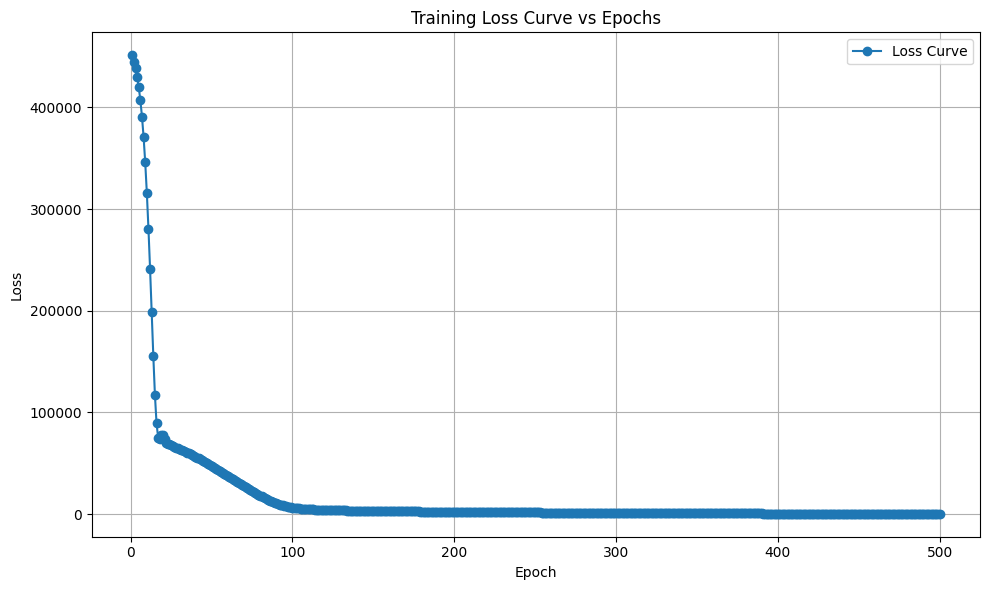

Temps d'entraînement du meilleur MLP : 7.77 secondes


In [8]:
import time

# Mesurer temps d'entraînement pour le meilleur modèle
start_time = time.time()
best_mlp.fit(X_train_calories_scale_dummy, y_train_calories)
# Capture the loss curve during training
loss_curve = best_mlp.loss_curve_

# Calculate training time
train_time_mlp = time.time() - start_time

# Plot the loss curve
plt.figure(figsize=(10, 6))
plt.plot(range(1, len(loss_curve) + 1), loss_curve, marker='o', label='Loss Curve')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training Loss Curve vs Epochs')
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()

print(f"Temps d'entraînement du meilleur MLP : {train_time_mlp:.2f} secondes")


**Interprétation** : Le meilleur modèle de réseau de neurones (MLP) a été entraîné via **GridSearchCV** avec une architecture de 3 couches cachées, utilisant la **fonction d'activation ReLU** et **l'optimiseur Adam**. Il obtient un **R² généralisé de 0.9728** et un **R² de 0.9845** sur l'ensemble de test, avec un **MSE de 1212.49**.

Les meilleurs hyperparamètres sélectionnés sont :
- Architecture : **(150, 100, 50)** (trois couches cachées)
- Fonction d'activation : **ReLU**
- Méthode d'optimisation : **Adam**
- Apprentissage : **learning rate constant**
- Régularisation (alpha) : **0.001**

En termes de performance pure, le réseau de neurones optimisé se situe juste en-dessous des modèles de **Gradient Boosting** (meilleur modèle avec R² généralisé ≈ 0.9903) **et XGBoost** (R² généralisé ≈ 0.9824), mais semble légèrement mieux généraliser que le modèle XGBoost (bien que ce dernier n'ait pas été optimisé) en termes de MSE (1212.49 pour le MPL contre 1377.15 pour XGBoost).

Le réseau de neurones a su **apprendre efficacement**, bien son **temps d'entraînement soit beaucoup plus important** par rapport aux modèles de ce niveau de performances (30 fois plus lent).



## Interprétation finale (comparaison des modèles)


L'ensemble des modèles évalués présente des performances très solides sur la prédiction des calories dépensées :

| Modèle             | R² Test  | MSE Test | Temps d'entraînement |
|:-------------------|:--------:|:--------:|:--------------------:|
| Gradient Boosting   | 0.9903   | 755.82   | ~0.21 sec par fold    |
| MLP (réseau de neurones) | 0.9845   | 1212.49  | ~6.7 sec (mesuré)        |
| XGBoost             | 0.9824   | 1377.15  | ~0.14 sec par fold    |
| Random Forest       | 0.9768   | 1812.48  | 5.2 sec (complet)     |

Le **Gradient Boosting** conserve une légère avance en termes de précision et d'erreur quadratique moyenne.  
Le **réseau de neurones** propose une alternative très compétitive, atteignant un niveau de performance intermédiaire entre Gradient Boosting et XGBoost.  
Le **temps d'entraînement** du MLP reste parfaitement acceptable, comparable à celui du Gradient Boosting.

Enfin, **XGBoost**, bien que légèrement en retrait sans tuning spécifique, surpasse malgré tout la **forêt aléatoire** en termes de précision et de vitesse.

---

**Conclusion générale** : (à modif)

> En résumé, les modèles de boosting et de réseaux de neurones surpassent les forêts aléatoires en termes de performance et d'efficacité.  
> Le Gradient Boosting apparaît comme le modèle le plus performant, tandis que le réseau de neurones constitue une alternative compétitive et rapide.  
> Tous les modèles sélectionnés généralisent correctement, confirmant la qualité du jeu de données et la robustesse des méthodes employées.

